# Following Salama BNN and pBNN

The wine data set he uses is strange by astrophysical standards. 
I'm using Sountsov and Angioi to make sense of it, and to modify it for 
the problem at hand

Oct 27, 2021



In [54]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


In [55]:
cluster_data=pd.read_csv("~/Data/cluster_data_0.3-0.6-msm.csv")
clusters = pd.DataFrame( {"central_sm":cluster_data["central_sm"]} )
clusters["measured_sm"] = cluster_data["measured_sm"]
clusters["halo_mass"] = cluster_data["halo_mass"]
clusters.head()
#

,central_sm,measured_sm,halo_mass
0,12.115618,12.491581,14.658120
1,11.894872,12.111751,14.089678
2,11.763473,12.208368,14.383239
3,11.820660,12.358756,14.287383
4,11.628624,12.131789,14.141557


In [434]:
def get_train_and_test_splits(X, y, train_percent, batch_size=1, dtype='float32'):
    
    X = X.astype(dtype)
    y = y.astype(dtype)
    dataset_size = y.size
    train_size = int(dataset_size*train_percent)
    
    # the dataset is very small and fits into memory.
    dataset = tf.data.Dataset.from_tensor_slices( (X, y))
    
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

#batch_size=1
X = clusters[clusters.columns[:-1]]
y = clusters[clusters.columns[-1]]
sample_size = y.size
#train_dataset, test_dataset = get_train_and_test_splits(X, y, 0.80, batch_size)
train_dataset, test_dataset = get_train_and_test_splits(X, y, 0.80)
total_dataset, junk = get_train_and_test_splits(X,y,1.00)
#

In [ ]:
# this overwrites the above

dataset = clusters
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset, diag_kind='kde')
csm = np.array(train_features['central_sm'])
msm = np.array(train_features['measured_sm'])
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.transpose(np.array([csm,msm])))

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [halo_mass]')
  plt.legend()
  plt.grid(True)
#plot_loss(history)

In [956]:
#~Soukovs

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(1*n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t,scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# from https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/24/01-DenseVariational-layer.html
def xprior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

def xposterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model


In [1132]:
# following https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/24/01-DenseVariational-layer.html

def ocreate_bnn_model(train_size, loss):
    learning_rate = 0.005
    learning_rate = 0.01
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16),
        #tfp.layers.DenseVariational(16, posterior, prior, kl_weight=1/train_size, activation='relu'),
        tfp.layers.DenseVariational(1, posterior, prior, kl_weight=1/train_size, kl_use_exact=True),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :1], scale=1)),
                #scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
    ])
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss,
    )

    return model

def ocreate_bnn_model(train_size, loss):
    learning_rate = 0.001
    #learning_rate = 0.01
    
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(16), 
    tfp.layers.DenseVariational(2, posterior, prior, kl_weight=1 / train_size),
    tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
    ])
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss,
    )

    return model

# original and best performing
def ocreate_bnn_model(train_size, loss):
    learning_rate = 0.001
    #learning_rate = 0.01
    
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(16),
      tf.keras.layers.Dense(2),  
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
    ])
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss,
    )

    return model

# 
def create_bnn_model(train_size, loss, norm):
    learning_rate = 0.001
    #learning_rate = 0.01
    
    model = tf.keras.Sequential([
      norm,
      #tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(2),  
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[..., 1:]))),
                #scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss,
    )

    return model



In [1123]:
# this is in place of the above and below 2 cells

# really, just an example

def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# bnn_model = build_and_compile_model(normalizer)
# bnn_model.summary()
# start=time.time()
# history = dnn_model.fit(
#     train_features,
#     train_labels,
#     validation_split=0.2,
#     verbose=0, epochs=100)
# print("fitting took {} seconds.".format(time.time()-start))

In [1135]:
loss= negloglik
bnn_model = create_bnn_model(sample_size, loss, normalizer)
bnn_model.summary()

start=time.time()
history = bnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=300)

print("\nfitting took {} seconds.".format(time.time()-start))
print("\nEvaluating model performance...")
rmse = bnn_model.evaluate(train_features, train_labels, verbose=1)
print("Train RMSE: {}".format(rmse))
rmse = bnn_model.evaluate(train_features, train_labels, verbose=1)
print("Test RMSE: {}".format(rmse))

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliza  (None, 2)                5         
 tion)                                                           
                                                                 
 dense_157 (Dense)           (None, 16)                48        
                                                                 
 dense_158 (Dense)           (None, 2)                 34        
                                                                 
 distribution_lambda_112 (Di  ((None, 1),              0         
 stributionLambda)            (None, 1))                         
                                                                 
Total params: 87
Trainable params: 82
Non-trainable params: 5
_________________________________________________________________

fitting took 29.87166404724121 seconds.

Evaluating mod


Evaluating model performance...
8/8 [==============================] - 1s 1ms/step - loss: 1.8375
Train RMSE: 1.837539792060852
8/8 [==============================] - 0s 7ms/step - loss: 1.8375
Test RMSE: 1.837539792060852


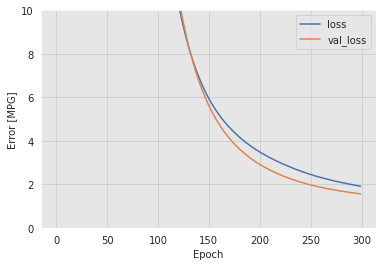

In [1136]:
plot_loss(history)
print("\nEvaluating model performance...")
rmse = bnn_model.evaluate(train_features, train_labels, verbose=1)
print("Train RMSE: {}".format(rmse))
rmse = bnn_model.evaluate(train_features, train_labels, verbose=1)
print("Test RMSE: {}".format(rmse))

In [975]:
def run_experiment(model, loss, train_dataset, test_dataset, batch_size=32):

    print("Start training the model..."); start=time.time()
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, verbose=0, batch_size=batch_size)
    print("Model training finished in....   {:.0f} seconds".format(time.time()-start))
    
    print("\nEvaluating model performance...")
    rmse = model.evaluate(train_dataset, verbose=1)
    print("Train RMSE: {}".format(rmse))
    rmse = model.evaluate(test_dataset, verbose=1)
    print("Test RMSE: {}".format(rmse))

In [980]:
mse_loss = tf.keras.losses.MeanSquaredError()
#negloglik = lambda y, p_y: -p_y.log_prob(y)
def negloglik(y_true, y_pred): return -y_pred.log_prob(y_true)
loss= negloglik
#loss = mse_loss

# batch gradient descent
batch_size = sample_size
# minibatch gradient descent
batch_size = 32
# stochastic gradient descent
batch_size = 1
batch_size = sample_size

#num_epochs = 5000
num_epochs = 100

bnn_model = create_bnn_model(sample_size, loss)
run_experiment(bnn_model, loss, train_dataset, test_dataset, batch_size=batch_size)

Start training the model...
Model training finished in....   224 seconds

Evaluating model performance...
229/229 [==============================] - 0s 906us/step - loss: 1.1401
Train RMSE: 1.1401478052139282
58/58 [==============================] - 0s 928us/step - loss: 1.1087
Test RMSE: 1.1086995601654053


In [1070]:
try :
    tx, ty = vectors_from_datasets(test_dataset) 
except:
    tx1 = test_dataset["central_sm"]
    tx2= test_dataset["measured_sm"]
    ty = test_dataset["halo_mass"]
    tx = np.transpose(np.array([tx1,tx2]))
#prediction = np.squeeze(bnn_model.predict(test_dataset))
prediction = np.squeeze(bnn_model.predict(X))
print("model shape:", prediction.shape)
pre=tf.math.reduce_mean(prediction, axis=0)
p=pre.numpy()
print(prediction[0:10],"...\n==\n mean:", pre)
p=prediction
#mu=p[0]; sigma=p[1];

model shape: (287,)
[14.987154 15.442999 14.52849  12.537413 14.060701 14.271037 14.039683
 15.318695 14.260012 13.017641] ...
==
 mean: tf.Tensor(14.287309, shape=(), dtype=float32)


In [1071]:
bnn_model.summary()
dummy_input = np.array([[0]])
model_prior = bnn_model.layers[0]._prior(dummy_input)
model_posterior = bnn_model.layers[0]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Posterior mean: ', model_posterior.mean().numpy())
print('Prior Variance: ', model_posterior.variance().numpy())
print('Posterior variance:', model_posterior.covariance().numpy()[0])
print('                   ', model_posterior.covariance().numpy()[1])

Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliza  (None, 2)                5         
 tion)                                                           
                                                                 
 dense_119 (Dense)           (None, 64)                192       
                                                                 
 dense_120 (Dense)           (None, 64)                4160      
                                                                 
 dense_121 (Dense)           (None, 2)                 130       
                                                                 
 distribution_lambda_99 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 4,487
Trainable params: 4,482
Non-trai

AttributeError: 'Normalization' object has no attribute '_prior'

(287,) (287, 2) (287,)


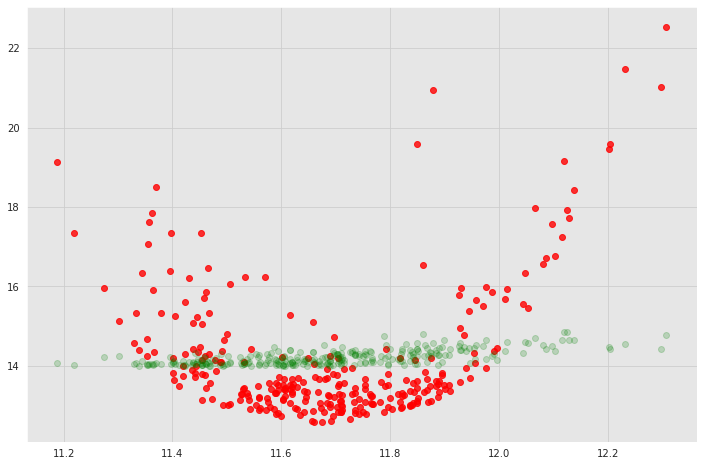

In [1137]:
X = clusters[clusters.columns[:-1]]; X=X.to_numpy()
y = clusters[clusters.columns[-1]];  y=y.to_numpy()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
for _ in range(1):
    y_model = bnn_model(X).sample(100000)
    y_model= tf.math.reduce_mean(y_model, axis=0)
    y_model = np.squeeze(y_model.numpy())
    print(y_model.shape, X.shape, y.shape)
    axes.scatter(X[:,0], y, color='green', alpha=0.2, zorder=10)
    axes.scatter(X[:,0], y_model, color='red', alpha=0.8, zorder=1)

/global/homes/a/annis/.conda/envs/tflow2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


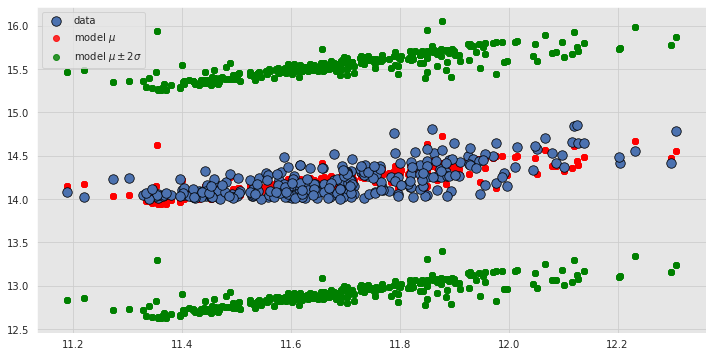

In [1119]:
def band_plot (model, X_train, y_train) :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    project_x = X_train[:,0]
    sns.scatterplot(project_x, y_train, alpha=1, label='data', zorder=10, s=90, edgecolor="k")

    for _ in range(5):
        y_model = model(X_train)
        y_hat = y_model.mean()
        y_hat_m2std = y_hat - 2 * y_model.stddev()
        y_hat_p2std = y_hat + 2 * y_model.stddev()
        std = np.squeeze(y_model.stddev().numpy())
        #print(std)
        
        fancy=False
        if fancy:
            samples = model(X_train).sample(1000)
            quantiles = tfp.stats.quantiles(samples, 10, axis=0, interpolation="linear")
            #print("quantiles",quantiles.shape)
            quantiles = quantiles.numpy()
            l90 = quantiles[1,:]
            u90 = quantiles[9,:]
            y_hat_m2std = l90 
            y_hat_p2std = u90
    
        if _ == 0:
            plt.scatter(project_x, y_hat, color='red', alpha=0.8, label='model $\mu$')
            plt.scatter(project_x, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
            plt.scatter(project_x, y_hat_p2std, color='green', alpha=0.8)
        else:
            plt.scatter(project_x, y_hat, color='red', alpha=0.8)
            plt.scatter(project_x, y_hat_m2std, color='green', alpha=0.8)
            plt.scatter(project_x, y_hat_p2std, color='green', alpha=0.8)
    plt.legend(loc='best')
    
X = clusters[clusters.columns[:-1]]; X=X.to_numpy()
y = clusters[clusters.columns[-1]];  y=y.to_numpy()

band_plot(bnn_model, X, y)
#

In [1106]:
samples = bnn_model(X).sample(1000)
quantiles = tfp.stats.quantiles(samples, 10, axis=0, interpolation="linear")
print("quantiles",quantiles.shape)
quantiles = quantiles.numpy()
l90 = quantiles[1,:]
u90 = quantiles[9,:]

quantiles (11, 287, 1)


In [1101]:
def vectors_from_datasets(dataset) :
    # assume there are just two columns, X and y
    rows = len(list(dataset.as_numpy_iterator()))
    cols = len(list(test_dataset.as_numpy_iterator())[0])
    #print (" rows, cols", rows,cols)
    X = []
    for j in test_dataset.as_numpy_iterator() : X.append(j[0])
    X =np.squeeze( np.array(X))
    y = []
    for j in test_dataset.as_numpy_iterator() : y.append(j[1])
    y =np.squeeze( np.array(y))
    return X,y


def compute_predictions(model, examples, targets, n_samples=10000, verbose=False):
    samples = bnn_model(examples).sample(n_samples)
    if verbose: print(samples.shape)
    samples = tf.squeeze(samples) # get rid of dim=1
    #samples = tf.reduce(samples)  # get rid of dim=0 guess not

    shape = samples.get_shape().as_list()
    if verbose: print(samples.shape)
    if verbose: print(shape, [shape[0], shape[1]])
    samples = tf.reshape(samples, [shape[0], shape[1]]) # i see a zero colum
    smean = tf.math.reduce_mean(samples,0).numpy()

    target_samples =np.broadcast_to(targets.numpy(), [shape[0], shape[1]])
    #target_samples =np.broadcast_to(targets.numpy(), [shape[0],])
    if verbose: print(target_samples.shape)
    size = shape[0]*shape[1]
    if verbose: print(samples.shape)
    quantiles = tfp.stats.quantiles(samples, 10, axis=0, interpolation="linear")
    if verbose: print("quantiles",quantiles.shape)
    quantiles = quantiles.numpy()
    l90 = quantiles[1,:]
    u90 = quantiles[9,:]

    
    samples = tf.reshape(samples, [size,]).numpy()
    target_samples = tf.reshape(target_samples, [size,]).numpy()
    

    mean = (smean-targets.numpy()).mean()
    std = (samples-target_samples).std()

    print("mean, std:   ",mean, std)
    return (smean, targets, samples, target_samples, u90, l90)

batch_size=32; s=10
#tx, ty = vectors_from_datasets(test_dataset) 
# tx, ty = vectors_from_datasets(test_dataset.unbatch().shuffle(batch_size * 10).batch(s))

#examples, targets = list(test_dataset.unbatch().shuffle(batch_size).batch(100))[0]
examples, targets = list(total_dataset.unbatch().shuffle(batch_size).batch(sample_size))[0]


sm,tm, st, ts, u90, l90 = compute_predictions(bnn_model, examples, targets)

2021-10-27 18:39:16.740555: W tensorflow/core/data/root_dataset.cc:175] Optimization loop failed: CANCELLED: Operation was cancelled


mean, std:    0.011053787 0.67114764


(287,) (287,) (287,) (287,)


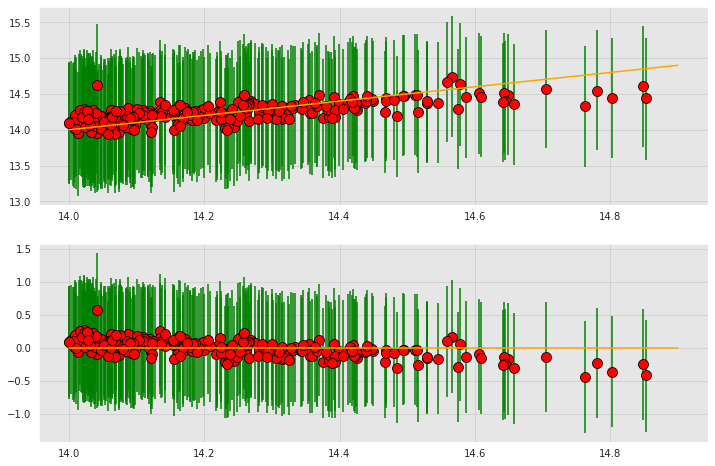

In [1102]:
print(tm.shape, sm.shape, l90.shape, u90.shape)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
#sns.scatterplot(x=t,y=s)
zp=-0.2;zp=0
axes[0].errorbar(tm,sm-zp,yerr=[sm-l90,u90-sm], color="green", ls="none", zorder=1)
sns.scatterplot(x=tm, y=sm-zp, color="red",s=100, edgecolor="k", zorder=10, ax=axes[0])
axes[0].plot([14.0,14.9], [14.0,14.9], color="orange",zorder=20)

axes[1].errorbar(tm,sm-tm-zp,yerr=[sm-l90,u90-sm], color="green", ls="none", zorder=1)
sns.scatterplot(x=tm, y=sm-tm-zp, color="red",s=100, edgecolor="k", zorder=10, ax=axes[1])
axes[1].plot([14.0,14.9], [0.0,0.0], color="orange",zorder=20)

## Let's follow another example, shall we?

https://www.tensorflow.org/tutorials/keras/regression

by Anonymous

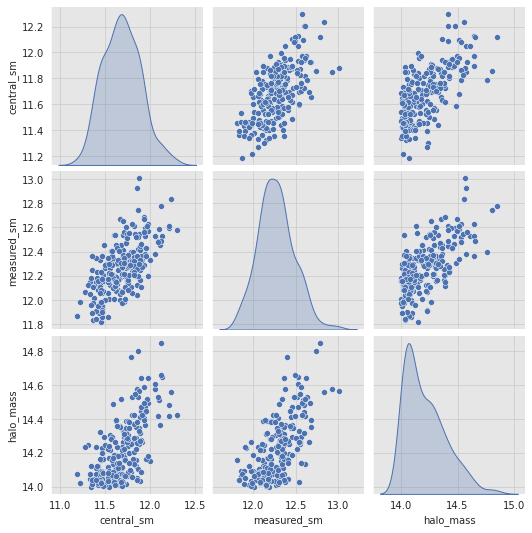

In [990]:
dataset = clusters
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset, diag_kind='kde')

In [993]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('halo_mass')
test_labels = test_features.pop("halo_mass")

In [994]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[11.682271 12.269593]]


In [995]:
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[11.49 12.45]]

Normalized: [[-0.94  0.87]]


In [1020]:
csm = np.array(train_features['central_sm'])
msm = np.array(train_features['measured_sm'])

csm_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
csm_normalizer.adapt(csm)

msm_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
msm_normalizer.adapt(msm)


In [1003]:
csm_model = tf.keras.Sequential([
    csm_normalizer,
    tf.keras.layers.Dense(units=1)
])

csm_model.summary()
csm_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_103 (Dense)           (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [1005]:
start=time.time()
history = csm_model.fit(
    train_features['central_sm'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
print("fitting took {} seconds.".format(time.time()-start))

fitting took 87.65023589134216 seconds.


,loss,val_loss,epoch
95,0.119191,0.122591,95
96,0.108774,0.101448,96
97,0.106727,0.101186,97
98,0.107380,0.113792,98
99,0.112149,0.100546,99


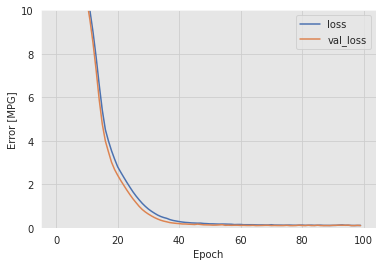

In [1039]:
pdef plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(history)
hist.tail()

In [1007]:
test_results = {}

test_results['csm_model'] = csm_model.evaluate(
    test_features['central_sm'],
    test_labels, verbose=0)

In [1016]:
x = tf.linspace(11.15, 12.4, 100)
y = csm_model.predict(x)

/global/homes/a/annis/.conda/envs/tflow2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


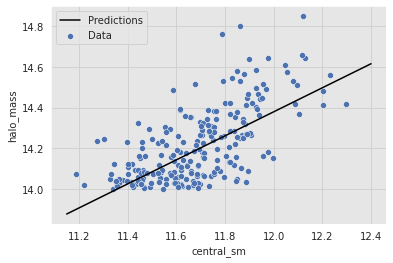

In [1017]:
def plot_csm(x, y):
  y=np.squeeze(y)
  sns.scatterplot(x=train_features['central_sm'], y=train_labels, label='Data')
  sns.lineplot(x, y, color='k', label='Predictions')
  plt.xlabel('central_sm')
  plt.ylabel('halo_mass')
  plt.legend()

plot_csm(x,y)

### linear regression with multiple inputs

In [1026]:
csm = np.array(train_features['central_sm'])
msm = np.array(train_features['measured_sm'])
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.transpose(np.array([csm,msm])))


In [1028]:
#linear_model.predict(train_features)
linear_model.layers[1].kernel

<tf.Variable 'dense_105/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[1.2387515 ],
       [0.48317277]], dtype=float32)>

In [1029]:

linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

#linear_model.predict(train_features)
#linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

start=time.time()
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
print("fitting took {} seconds.".format(time.time()-start))

fitting took 86.81544542312622 seconds.


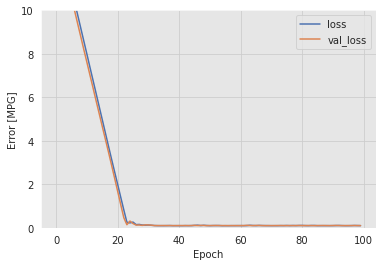

In [1030]:
plot_loss(history)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In [1033]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#### Regression using a DNN and a single input

In [1035]:
dnn_csm_model = build_and_compile_model(csm_normalizer)
dnn_csm_model.summary()

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_110 (Dense)           (None, 64)                128       
                                                                 
 dense_111 (Dense)           (None, 64)                4160      
                                                                 
 dense_112 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [1037]:
start=time.time()
history = dnn_csm_model.fit(
    train_features['central_sm'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
print("fitting took {} seconds.".format(time.time()-start))

fitting took 69.66335701942444 seconds.


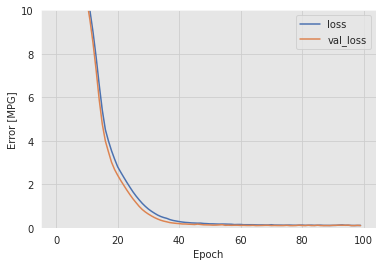

In [1040]:
plot_loss(history)


/global/homes/a/annis/.conda/envs/tflow2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


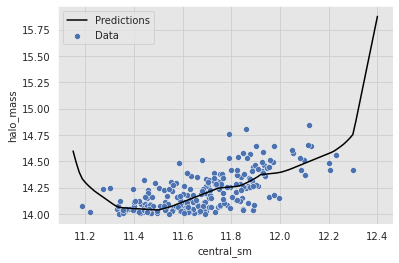

In [1041]:
x = tf.linspace(11.15, 12.4, 100)
y = dnn_csm_model.predict(x)
plot_csm(x,y)

In [1043]:
test_results['dnn_csm_model'] = dnn_csm_model.evaluate(
    test_features['central_sm'], test_labels,
    verbose=0)

#### Regression using a DNN and multiple inputs

In [1044]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_14 (Normaliza  (None, 2)                5         
 tion)                                                           
                                                                 
 dense_113 (Dense)           (None, 64)                192       
                                                                 
 dense_114 (Dense)           (None, 64)                4160      
                                                                 
 dense_115 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [1045]:
start=time.time()
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
print("fitting took {} seconds.".format(time.time()-start))

fitting took 34.443848848342896 seconds.


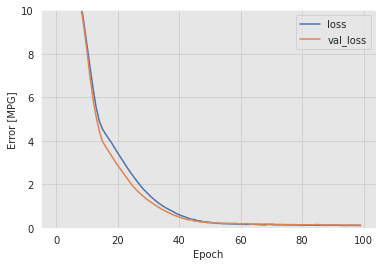

In [1046]:
plot_loss(history)

In [1047]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

#### Comparative Performance

In [1048]:
pd.DataFrame(test_results, index=['Mean absolute error [halo_mass]']).T

,Mean absolute error [halo_mass]
csm_model,0.109887
linear_model,0.106147
dnn_csm_model,0.103511
dnn_model,0.108028


#### Make Predictions

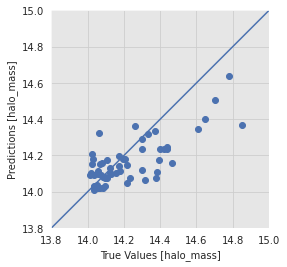

In [1054]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [halo_mass]')
plt.ylabel('Predictions [halo_mass]')
lims = [13.8, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

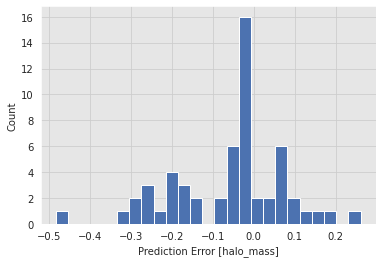

In [1052]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [halo_mass]')
_ = plt.ylabel('Count')